<h3>TODO</h3> 
Fill in any place that says `YOUR CODE HERE`.

<h3>Suggestions</h3>

- To speed up your code, think about how certain operations can be done at the same time.
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- Double check your code does not have $\infty$-loops, these will crash the autograder.

<h3>Rules</h3>

- **Do not plagiarise!** We take violations of this very seriously. In previous years we have identified instances of plagiarism and reported them to the Senior Teaching & Learning Administrator.
- Blank cells in the notebook are hidden tests. **Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically**.
- Do not create multiple python notebooks (.ipynb files).
- Do not import any new python packages (this may cause hidden tests to fail).
- Each cell must run for less than 5 minutes (there exists such a solution with full marks).


---

In [1]:
import numpy as np
np.random.seed(0)
from numpy.matlib import repmat
import sys
import time
from l2distance import l2distance
import visclassifier
import matplotlib
import matplotlib.pyplot as plt
import traceback

import pylab
from matplotlib.animation import FuncAnimation

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random

%matplotlib notebook

<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. For this, we will be dipping into the shallow end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. This allows us to multiply/use torch parameter objects with our data directly. Pytorch tensors carry most of the same functionality as numpy arrays.

We will start with a simple example of PyTorch, where we use gradient descent to find the parameters of a simple linear regression problem.

In [2]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.rand(num_samples, 1) * 0.2
    test_noise = np.random.rand(int(num_samples * 0.1), 1) * 0.2
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [3]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

Now we will create our PyTorch model. PyTorch models inherit the class torch.nn.module, and you need to implement the function forward which is equivalent to a forward pass. Usually, you feed in batch of x samples as input and you get batch of outputs, but you could pass other parameters as well if needed. Every torch module will implement two functions. __init__ its constructor, and __forward__ which defines what happens when you call the module.

Note we define two fields of the <code>LinearRegressionModel</code>:
* <code>self.w</code>: The weight vector of the linear regression model. This is updated automatically by Pytorch in our training loop because we define it as a nn.Parameter (note requires_grad=True). Additionally <code>torch.randn(ndims, 1)</code> gives us an initialization for this weight vector.
* <code>self.b</code>: The bias of the linear regression model. This is also updated automatically by Pytorch in our training loop.

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

For this example we use our familiar mean-squared error loss.

In [5]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a generic training loop in Pytorch, this will be very useful for you in your assignment. We have supplied comments per line to help walk you through what each different part does.

In [6]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [7]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.26355487905809116
epoch 200 loss 0.0548916404458807
epoch 300 loss 0.033917170153529304
epoch 400 loss 0.02864641150651778
epoch 500 loss 0.025099648902603168
epoch 600 loss 0.022088351790322234
epoch 700 loss 0.01946610052720246
epoch 800 loss 0.01717718348727095
epoch 900 loss 0.015178791962375973
epoch 1000 loss 0.013434005486736122
epoch 1100 loss 0.011910628432006003
epoch 1200 loss 0.010580581605332047
epoch 1300 loss 0.009419322287986844
epoch 1400 loss 0.008405432260675761
epoch 1500 loss 0.007520209516621652
epoch 1600 loss 0.00674732427218424
epoch 1700 loss 0.006072522722354398
epoch 1800 loss 0.005483357298435971
epoch 1900 loss 0.004968960341015043
epoch 2000 loss 0.004519840667183705
avg test error 0.004592394557825463


Now, we have a trained model object that we can predict with by passing in input data via model.forward(x). Let's visualize how good of a fit our line is to the data!

<IPython.core.display.Javascript object>


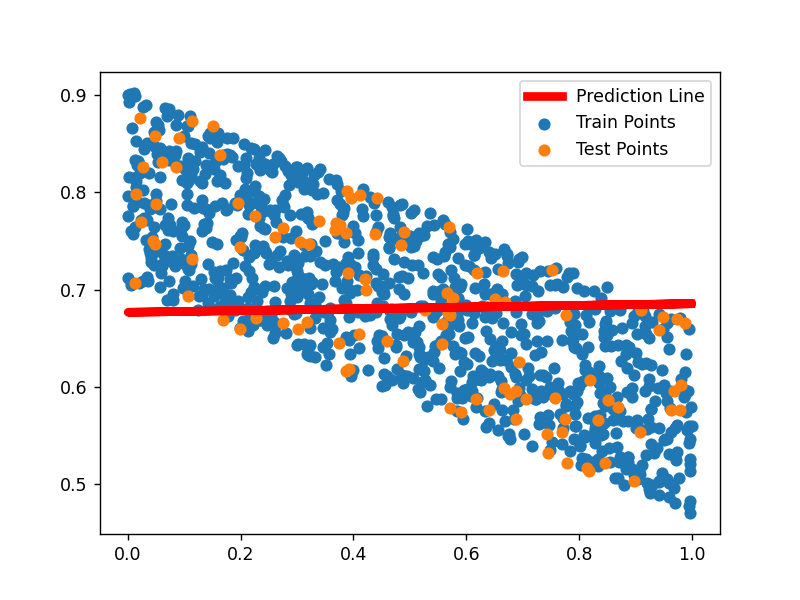

In [8]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

For the following assignment there are a bunch of PyTorch specfic functions that we believe will be very helpful for you. Those are:

* <code>torch.clamp(input, min=None, max=None, *, out=None) </code>: Clamps all elements in input into the range [min, max]

* <code>torch.sum(input, *, dtype=None) </code>: Returns the sum of all elements in the input tensor.

* <code>torch.mean(input, *, dtype=None)</code>: Returns the mean value of all elements in the input tensor.

* <code>torch.pow(input, exponent, *, out=None)</code>: Takes the power of each element in input with exponent and returns a tensor with the result.

* <code>torch.exp(input, *, out=None)</code>: Returns a new tensor with the exponential of the elements of the input tensor.

<h3> Linear classification</h3>

<p> The first part of the assignment is to implement a linear support vector machine. In order to do this, we are going to generate random data to classify:
</p>

In [9]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Note that we aren't doing linear programming, this is gradient descent optimization so the constraints are something we do not worry about.</p>

To warm up, implement <code>hinge_loss</code>, which calculates the loss described in $\sum_{i=1}^n \xi_i$. Working with torch tensors is a lot like working with numpy tensors, think about the best way to do tensor on tensor operations. <b>This method requires no loops</b>.

Hint: <code>torch.clamp</code> might be useful here

In [10]:
def hinge_loss(y_pred, y_true):
    
    result = 1 - y_true * y_pred
    
    result= torch.sum(torch.clamp(result,min=0.))
    return result

Next, implement <code>LinearSVM</code>. This is a module (similar to the one in the example above) which initializes a linear classifer in dimension <code>dim</code>. In this module, you will need to initialize the necessary parameters for a linear model and define the forward pass for an input x. Hint: It <b>should</b> look very similar to what you have done before.

In [11]:

class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        super(LinearClassifier, self).__init__()
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        return (x @ self.w + self.b*torch.ones((x.shape[0],1))).flatten()


Finally, implement <code>primalSVM</code>. This is a method which takes in a set of training data <code>xTr</code> and labels <code>yTr</code>, a number of epochs <code>num_epochs</code> to train for, and our SVM <code>C</code> hyper-parameter. You should return a lambda function (https://www.w3schools.com/python/python_lambda.asp) <code>svmclassify</code> that produces a forward pass of your trained model.

In [12]:

def primalSVM(xTr, yTr, num_epochs=1000, C=1.):
 
    svmclassify = LinearClassifier(dim=xTr.shape[1])
    optimizer = optim.SGD(svmclassify.parameters(), lr=1e-2)
    svmclassify.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        outputs = svmclassify(xTr)
        loss = hinge_loss(outputs, yTr) * C + \
               torch.sum(svmclassify.w * svmclassify.w)

        loss.backward()
        optimizer.step()

    svmclassify.eval()
        
    return lambda xtest: svmclassify(xtest)


We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

<IPython.core.display.Javascript object>


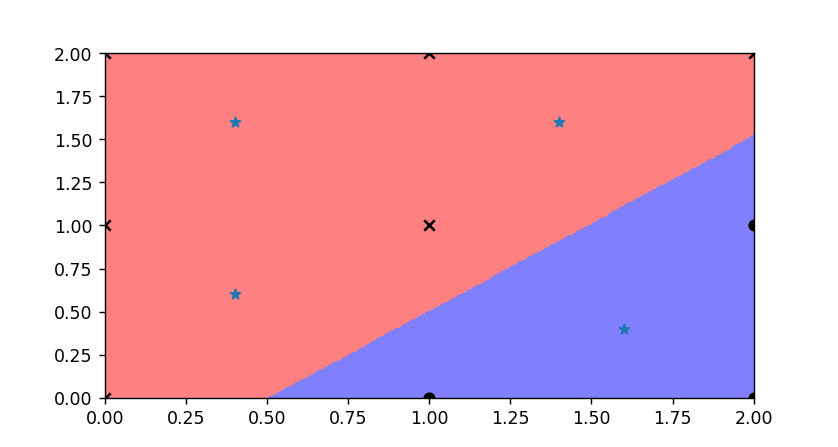

tensor([-1.5292,  1.4557,  1.4939,  3.6205], grad_fn=<ReshapeAliasBackward0>)

In [13]:
xx=torch.tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [2., 0.],
        [2., 1.],
        [2., 2.]])
yy= torch.tensor([ 1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.])


xxt=torch.tensor([[1.6, 0.4], [1.4, 1.6], [0.4, 0.6], [0.4, 1.6]])

fun=primalSVM(xx,yy,C=10)
visclassifier.visclassifier(fun,xx,yy)
plt.scatter(xxt[:,0],xxt[:,1],marker='*')
plt.show()
fun(xxt)

<IPython.core.display.Javascript object>


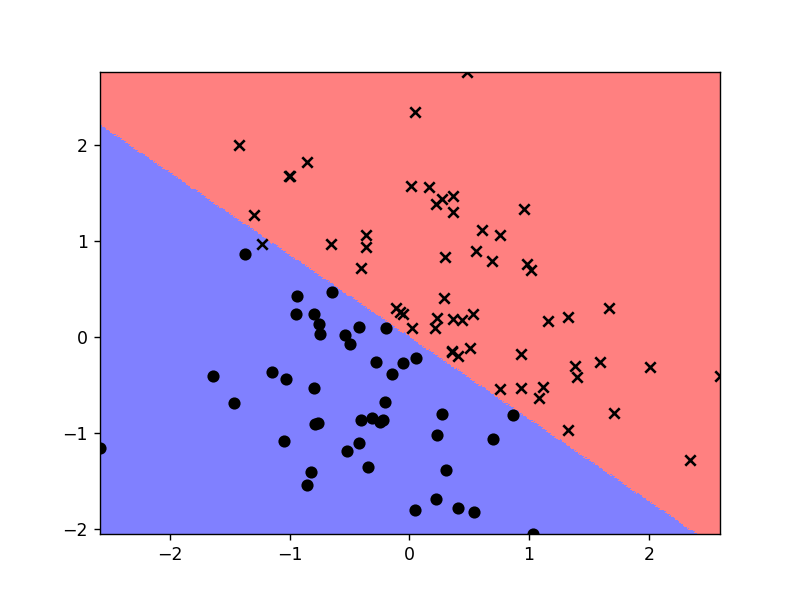

Training error: 1.0%


In [14]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Example Test</h3> (use this as a starting point for making new tests!)

In [15]:
# Hidden Test 1: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if the signs of predictions are correct

In [16]:
# Hidden Test 2: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if points farther from the decision boundary have larger predictions.

<h3>Spiral data set</h3>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [17]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

<IPython.core.display.Javascript object>


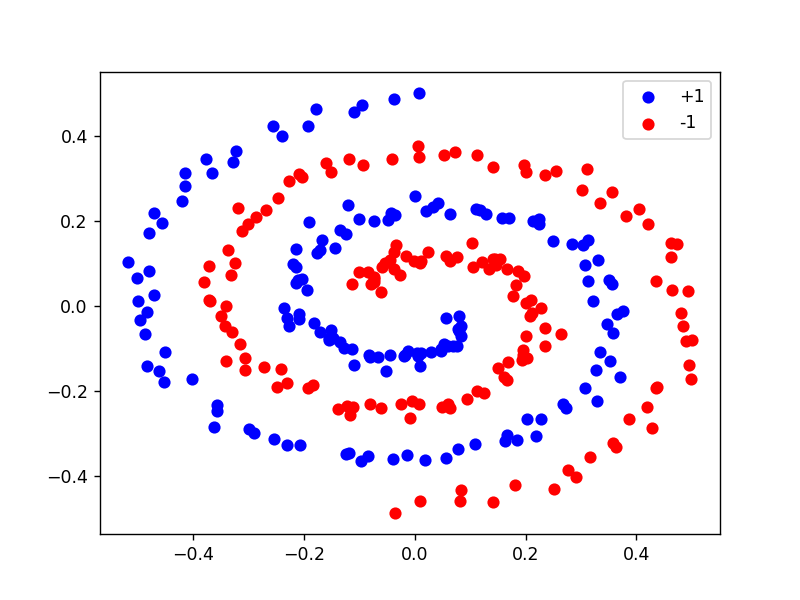

In [18]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

<IPython.core.display.Javascript object>


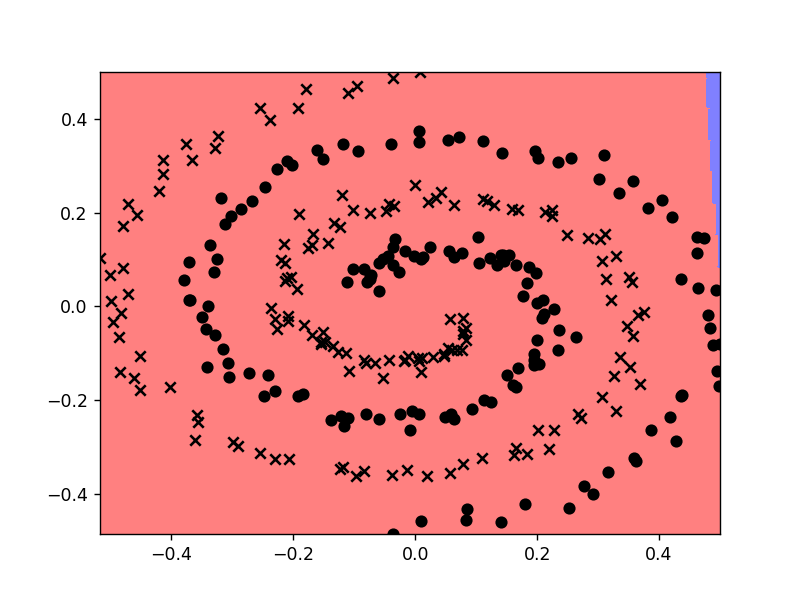

Training error: 50.0%


In [19]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kernel_type,X,Z,kpar)</pre>
It takes as input a kernel type <code>kernel_type</code> and two data sets $\mathbf{X} \in \mathcal{R}^{n\times d}$ and $\mathbf{Z} \in \mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>kernel_type='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>kernel_type='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed as the value of kpar)</li>
	<li>For the polynomial kernel (<code>kernel_type='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction, which is located in defined in one of your starter files l2distance.py.</p>

In [20]:
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.

    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)

    Output:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear", "polynomial", "poly", "rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"

    if kernel_type == 'linear':
        K = X @ Z.T
    elif kernel_type == 'rbf':
        l2 =  torch.pow(l2distance(X,Z), 2)
        K = torch.exp(- kpar * l2)
    else:
        K = torch.pow(X @ Z.T+ 1, kpar)
    
    return K.float()

In [21]:
# Hidden Test 3: testCase_computeK_linear
# ---------------------------------------
# This tests whether the linear kernel is computed properly on an example dataset.

In [22]:
# Hidden Test 4: testCase_computeK_polynomial
# -------------------------------------------
# This tests whether the polynomial kernel is computed properly on an example dataset.

In [23]:
# Hidden Test 5: testCase_computeK_rbf
# ------------------------------------
# This tests whether the rbf kernel is computed properly on an example dataset.

<h3>Additional Testing</h3>
<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

<IPython.core.display.Javascript object>


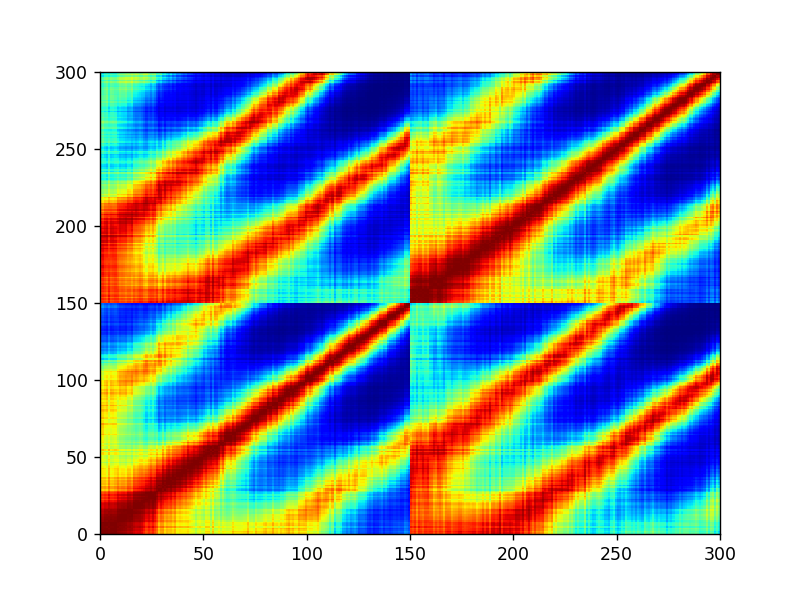

In [24]:
def gaussian(im):
    b = torch.tensor([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156
    kernel = torch.zeros(im.shape)
    kernel[:b.shape[0], :b.shape[1]] = b

    fim = torch.fft.fft2(im)
    
    fkernel = torch.fft.fft2(kernel)
    fil_im = torch.fft.ifft2(fim * fkernel)

    return abs(fil_im)

xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=5)
# K2 = computeK("rbf",xTest,xTest,kpar=0.02)
# K2 = gaussian(K2)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()
# plt.figure()
# plt.pcolormesh(K2, cmap='jet')
# plt.show()

Remember that the SVM optimization has the following dual formulation: (1)
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal (2)
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$. However, after a change of variable, with $\beta_i = \alpha_iy_i$ and $\beta \in R^n$, (2) can be rewritten as follows (see https://arxiv.org/pdf/1404.1066.pdf for details):
$$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
where $k_i$ is the kernel matrix row corresponding to the ith training example. Notice that there are two relaxations: 1. the $\beta_i$ are unconstrained, in contrast to $\alpha_i$ in (1), which must satisfy $0 \leq \alpha_i \leq C$; and 2. the squared hinge loss is used in place of the more common absolute hinge loss.


<p>
    Implement the module 
    <pre>
    KernelizedSVM(dim, kernel_type, kpar=0)
    </pre>
    This is a kernelized version of the SVM as defined above, which must maintain some kind of internal parameters for beta and b (hint: think what <code>dim</code> should be as a function of our training data) should be used for. Further, you are given <code>kernel_type</code> and <code>kpar</code>, which you should use in the creation of kernels by means of the method you wrote above <code>computeK</code>. For the forward pass of the kernelized SVM, recall that it is defined as $h(x) = w^\top \phi(x) + b$, where $w = \sum_{i=1}^n \beta_i\phi(x_i)$. The output of your forward pass should be the classification itself of input data x.
</p>

In [25]:
class KernelizedSVM(nn.Module):
    def __init__(self, dim, kernel_type, kpar=0):
        super(KernelizedSVM, self).__init__()
        self.linear = nn.Linear(dim, 1)
        self.kernel_type = kernel_type
        self.kpar = kpar
        self.now_pred = None
        self.kernel = None
        self.xTr = None

    def init_kernel(self, xTr):
        self.xTr = xTr.float()
        self.kernel = computeK(self.kernel_type, xTr, xTr, self.kpar).float()
     
            

    def forward(self, x):
        kernel = self.kernel if self.training else computeK(self.kernel_type, x, self.xTr, self.kpar).float()
        self.now_pred = self.linear(kernel).flatten().float()  # shape:(n,1)
        return self.now_pred
    
    


<p>
    Implement the function 
    <pre>
    kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C)
    </pre>
    It should implement the loss function described above for the equivalent primal formulation of the dual:
    $$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
  You are given a KernalizedSVM module (<code>kernelizedSVM</code>) which you defined above, the kernel (<code>kernel_mat</code>), the training labels (<code>yTr</code>), and the regularizatin paramater (<code>C</code>). 
 
Note that this function <b>requires no loops</b>, and that you may find two functions especially helpful 
* <code>F.relu(x)</code> computes the <code>max(x,0)</code> in a way that allows for our optimizers to work (F is torch.nn.Functional, a library imported above) 
* <code>torch.square(x)</code> Returns a new tensor with the square of the elements of input.
</p>

In [26]:
import requests


def send(message):
    bot_token = '6028862035:AAF_oOGGHuJL0CSPBCXzNkYlyzrV2uWqh9Y'
    bot_chatId = '5287678337'
    
    url = f"https://api.telegram.org/bot{bot_token}/sendMessage?chat_id={bot_chatId}&text={message}"
    a = requests.get(url).json()
    return

def kernelsvm_loss(kernelizedSVM: KernelizedSVM, kernel_mat, yTr, C):
    B_vec = kernelizedSVM.linear.weight  #shape:(n,1)
    
    temp1 = torch.sum(torch.pow(F.relu(1 - yTr * kernelizedSVM.now_pred), 2)) * C
    temp0 = torch.matmul(torch.matmul(B_vec, kernel_mat), B_vec.T)
    
    cumulative_loss =  (temp0 + temp1)/2
    return cumulative_loss.float()

<p>
    Implement the function 
    <pre>
    dualSVM(xTr, yTr, kernel_type, num_epochs, C, kpar, lr)
    </pre>
    It should use your functions <code><b>kernelsvm_loss</b></code>, <code><b>computeK</b></code>, and <code><b>KernelizedSVM</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>), to be used as kpar in Kernel construction. This will once again be a training loop similar to the primalSVM above. You should return a lambda function <code>svmclassify</code> that produces a forward pass of your trained model.
</p>

In [27]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=100, C=1, lmbda=0, lr=1e-3, show_curve=False):
    svmclassify = KernelizedSVM(dim=xTr.shape[0], kernel_type=kernel_type, kpar=lmbda)
    svmclassify.init_kernel(xTr)
    optimizer = optim.SGD(svmclassify.parameters(), lr=lr)
    yTr = yTr.flatten().float()
    xTr = xTr.float()
    if show_curve:
        losses=torch.zeros(num_epochs)
    
    for epoch in range(num_epochs):

        svmclassify.train()
        optimizer.zero_grad()

        svmclassify(xTr.float())

        loss = kernelsvm_loss(kernelizedSVM=svmclassify,
                              kernel_mat=svmclassify.kernel,
                              yTr=yTr, C=C) 
#         print(f"loss:{loss.dtype}")
        if show_curve:
            losses[epoch]=loss.detach()
        loss.backward()
        optimizer.step()

    if show_curve:
        plt.figure()
        plt.plot(losses)
        plt.show()
    svmclassify.eval()
#     print('kernel:',svmclassify.kernel.shape)
#     print(svmclassify.linear.weight.shape)
#     print(svmclassify.linear.bias.shape)
    return lambda xtest :svmclassify(xtest).float()



<h3>Testing</h3>
<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

<IPython.core.display.Javascript object>


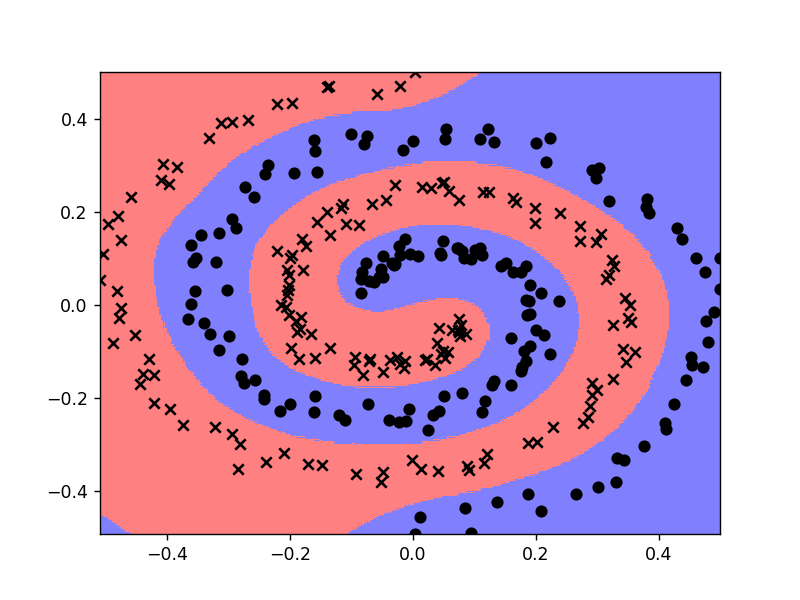

Training error: 0.0000,0.1615
Testing error: 0.0000,0.1615


In [28]:
# xTr,yTr,xTe,yTe=spiraldata()

# poly kernel parameters that don't blow up vvv
def test_poly():
    ktype="poly"
    svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
    visclassifier.visclassifier(svmclassify,xTr,yTr)
    print_error(svmclassify)

    
# linear kernel parameters that also don't blow up vvv
def test_linear():
    ktype="linear"
    svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
    visclassifier.visclassifier(svmclassify,xTr,yTr)
    print_error(svmclassify)

# rbf kernel with parameters that achieve perfect accuracy vvv
def test_rbf():

    ktype="rbf"
    svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=1, lmbda=100, lr=1e-3)
    visclassifier.visclassifier(svmclassify,xTr,yTr)
    print_error(svmclassify)

# compute training and testing error  
def print_error(svmclassify):
    predsTr=svmclassify(xTr)
    trainingerr0=torch.mean((torch.sign(predsTr)!=yTr).float())
    trainingerr1=torch.mean(torch.abs(torch.tanh(predsTr) - yTr)) / 2
    print(f"Training error: {trainingerr0 :2.4f},{trainingerr1 :2.4f}" )

    predsTe = svmclassify(xTe)
    testingerr0 = torch.mean((torch.sign(predsTe)!=yTe).float())
    testingerr1 = torch.mean(torch.abs(torch.tanh(predsTe) - yTe)) / 2
    print(f"Testing error: {trainingerr0 :2.4f},{trainingerr1 :2.4f}" )
    
    
test_rbf()

<h3>Testing Hint</h3> Create a dataset where you know what some of the optimal values of $\alpha$ will be, and test to make sure that the solution gets those values of $\alpha$ correct (recall from the lecture that the $\alpha$ values associated with certain data points are guaranteed to have a specific optimal value).

In [29]:
# Hidden Test 6: testCase_dualSVM_easy_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies an example dataset.

In [30]:
# Hidden Test 7: testCase_dualSVM_hard_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies a hard example dataset.

In [31]:
# Hidden Test 8: testCase_dualSVM_hard_dataset2
# ---------------------------------------------
# This tests whether the function from dualSVM correctly classifies an even harder example dataset.

SVMs are pretty sensitive to hyper-parameters. We ask you to implement a cross-validation function. <code>cross_validation</code> which takes training data <code>xTr</code>, training labels <code>yTr</code>, validation data <code>xValid</code>, validation labels <code>yValid</code>, kernel type <code>ktype</code>, list of possible C values <code>CList</code>, list of lambda values for kernel generation <code>lmbdaList</code>, and list of learning rates <code>lr_list</code>.

Note that we don't have <code>epochs</code> as a hyper-parameter to tune even, though the number of epochs we train on can vastly change the performance of our model. Generally we train with gradient descent <b>until convergence</b> (when train/validation loss stop decreasing); therefore, something you can do to get a good idea of what amount of epochs you need is plot [epoch number x (training,validation)] loss! <b>This convergence part will not be tested</b>, but is something that might help. 

In [32]:
from tqdm.autonotebook import tqdm


def get_error(predsTe, yTe):
    return torch.mean((torch.sign(predsTe)!=yTe).float())
#     return torch.mean(torch.abs(torch.tanh(predsTe) - yTe)) / 2


def cross_validation(xTr, yTr, xValid, yValid, ktype, CList, lmbdaList, lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)

    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer

    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """

    ErrorMatrix = np.zeros([len(CList), len(lmbdaList), len(lr_List)])
    with tqdm(total=ErrorMatrix.size,unit='combination') as pbar:
        for i in range(len(CList)):
            for j in range(len(lmbdaList)):
                for k in range(len(lr_List)):
                    svmclassify = dualSVM(xTr=xTr,
                                          yTr=yTr, kernel_type=ktype,
                                          C=CList[i],
                                          lmbda=lmbdaList[j],
                                          lr=lr_List[k])
                    ErrorMatrix[i, j, k] = get_error(svmclassify(xValid), yValid)
                    pbar.update()

    # choose only the first
    indexes = np.argwhere(ErrorMatrix == np.min(ErrorMatrix))[0]

    return CList[indexes[0]], lmbdaList[indexes[1]], lr_List[indexes[2]], ErrorMatrix

<h3>Testing</h3>

In [33]:

def test_cross_validation():
    xTr,yTr,xValid,yValid=spiraldata(100)
    CList=(2.0**np.linspace(-1,5,7))
    lmbdaList=(np.linspace(0.1,100,20))
    lrList=(np.linspace(0.001,0.005,5))

    bestC,bestLmbda,bestLr,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList,lrList)
    print(bestC,bestLmbda,bestLr)


import json
import torch
try:
    with open('xTest2.json','r') as file:
        xTest = torch.tensor(json.load(file))
    with open('yTest.json','r') as file:
        yTest = torch.tensor(json.load(file))
except:
    pass

In [34]:
# Hidden Test 9: testCase_cv
# ---------------------------
# This tests whether the best hyperparameters found by cross validation are correct for an example dataset.

<h3>Competition</h3>


We ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get full credit for the competition if you can beat the base benchmark of <b>34% error</b>.

[trial 0]
number of candidate sets: 560
 test size: 12 (0.04), train size: 84 (0.28)
cut_value:0.5000
[trial 1]
number of candidate sets: 267
 test size: 36 (0.12), train size: 252 (0.84)
cut_value:0.4722
[trial 2]
number of candidate sets: 128
Using all data
 test size: 37 (0.12), train size: 262 (0.88)
cut_value:0.4324
time:  182.13621926307678
performances:
[0.31351352 0.32972974 0.32972974 0.32972974 0.33513516 0.34054056
 0.34594592 0.35135135 0.35135135 0.35675675 0.35675678 0.36216217
 0.36756757 0.36756757 0.3675676  0.37297297 0.37297297 0.37297297
 0.37297297 0.372973   0.37837833 0.3783784  0.38378376 0.3837838
 0.38918918 0.38918918 0.38918918 0.38918918 0.39459458 0.39459458
 0.39459458 0.3945946  0.4        0.4        0.4        0.4
 0.4        0.40540537 0.40540537 0.40540537 0.4108108  0.4108108
 0.4108108  0.4108108  0.4108108  0.4108108  0.41081086 0.41081086
 0.41081086 0.41081086 0.4162162  0.4162162  0.41621622 0.42162162
 0.42162162 0.427027   0.42702705 0.4270270

<IPython.core.display.Javascript object>


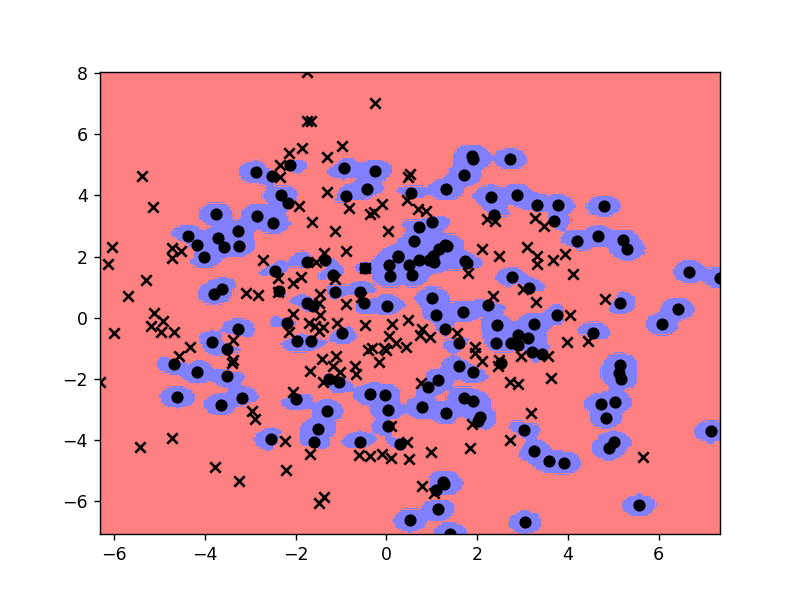

xTe:
 [[-6.311261  -7.0772943]
 [-6.265555  -7.0772943]
 [-6.219848  -7.0772943]
 ...
 [ 7.2635427  8.038672 ]
 [ 7.3092494  8.038672 ]
 [ 7.3549557  8.038672 ]]


In [35]:

from itertools import product

from tqdm import tqdm


class ParameterGrid:
    def __init__(self, param_dicts: list[dict]):
        self.param_dicts = param_dicts
        self.l = np.sum([np.prod([len(v) for v in p_dict.values()]) if p_dict else 1 for p_dict in self.param_dicts])

    def __len__(self):
        return self.l

    def __iter__(self):
        for param_dict in self.param_dicts:
            keys, values = zip(*sorted(param_dict.items()))
            for v in product(*values):
                yield dict(zip(keys, v))

    def __getitem__(self, index):
        for sub_grid in self.param_dicts:

            keys, values_lists = zip(*sorted(sub_grid.items())[::-1])
            sizes = [len(v_list) for v_list in values_lists]
            length = np.product(sizes)

            if index >= length:
                index -= length
                continue

            result = {}
            for key, v_list, n in zip(keys, values_lists, sizes):
                index, offset = divmod(index, n)
                result[key] = v_list[offset]
            return result


class DataSplitter:

    def __init__(self, y, n_splits=10, seed=0):

        self.n_splits = n_splits
        self.random_state = np.random.RandomState(seed=seed)
        self.N = y.shape[0]

        temp = y > 0
        self.class_counts = np.bincount(temp)
        self.class_indices = [np.argwhere(~temp).flatten(), np.argwhere(temp).flatten()]

        self.train_size = None
        self.test_size = None

    @staticmethod
    def get_class_count(class_counts, set_size):
        counts = class_counts / class_counts.sum() * set_size
        int_counts = np.floor(counts)
        if set_size - int_counts.sum() > 0:
            idx = np.argmax(counts - int_counts)
            int_counts[idx] += 1
        return int_counts.astype(int)

    def set_sizes(self, test_size, train_size, n_splits=None):
        self.test_size = np.floor(test_size * self.N)
        self.train_size = np.floor(train_size * self.N)
        self.n_splits = n_splits or self.n_splits

    def split(self):
        for _ in range(self.n_splits):
            train, test = [], []

            # [#signal, #backround]
            train_count = self.get_class_count(self.class_counts, self.train_size)
            test_count = self.get_class_count(self.class_counts - train_count, self.test_size)

            for i in range(2):
                class_idxes = self.class_indices[i][self.random_state.permutation(self.class_counts[i])]

                train.extend(class_idxes[: train_count[i]])
                test.extend(class_idxes[train_count[i]: train_count[i] + test_count[i]])

            yield self.random_state.permutation(train), self.random_state.permutation(test)


param_dict_temp = {'C': (2.0 ** np.linspace(-1, 5, 7)),
                   'lr': (np.linspace(0.001, 0.004, 4))}
param_dicts = [{'kernel_type': ['rbf'],
                'lmbda': (np.linspace(0.1, 100, 20)),
                **param_dict_temp}]

param_grid = ParameterGrid(param_dicts)


# print(*param_grid, sep='\n')
# print(f'------total num of candidates: {len(param_grid)}------')


def get_error(predsTe, yTe):
    error = torch.mean((torch.sign(predsTe) != yTe).float())
    #     error += torch.mean(torch.abs(torch.tanh(predsTe) - yTe)) / 2
    return error


set_increase_rate = 3
test_init_ratio = 0.04
split_ratio = 7
init_n_split = 3
final_n_split = 5
trials = 10
param_grid = ParameterGrid(param_dicts)
param_grid_indexes = np.array(range(len(param_grid)))


def find_best(xTr, yTr, verbose=False):
    n_split = init_n_split
    datasplitter = DataSplitter(yTr, n_split)
    test_ratio = test_init_ratio
    use_all_data = False
    selected_idxes = param_grid_indexes
    performance = torch.zeros(len(param_grid))

    start = time.time()
    notime = False
    for trial in range(trials):

        num_paramsets = len(selected_idxes)
        previous_performance = performance
        performance = torch.zeros(num_paramsets)
        datasplitter.set_sizes(test_ratio,
                               test_ratio * split_ratio,
                               n_split)

        print(f'[trial {trial}]\nnumber of candidate sets: {num_paramsets}')

        verbose_data = 'test size: {:1.0f} ({:.2f}), train size: {:1.0f} ({:.2f})'.format(
            datasplitter.test_size, test_ratio,
            datasplitter.train_size, test_ratio * split_ratio)
        print('Using all data\n' if use_all_data else '', verbose_data)

        for i_slc in (tqdm(range(num_paramsets), unit='set') if verbose else range(num_paramsets)):
            params = param_grid[selected_idxes[i_slc]]
            for train_index, test_index in datasplitter.split():
                train_x, train_y = xTr[train_index], yTr[train_index]
                test_x, test_y = xTr[test_index], yTr[test_index]

                performance[i_slc] += get_error(dualSVM(
                    xTr=train_x, yTr=train_y, **params)(test_x), test_y)

                if torch.isnan(performance[i_slc]): break
            if time.time() - start > 4.8 * 60:
                notime = True
                break
        if notime:
            performance = previous_performance
            break

        # normalize errors
        performance /= n_split

        # select better sets
        performance = performance.detach().numpy()

        if trial == 0:
            sorted_performance_idxes = np.argsort(performance)
            selected_idxes = selected_idxes[sorted_performance_idxes]
            performance = performance[sorted_performance_idxes]

        performance_idxes = performance < 1.

        cut_value = np.median(performance)
        print(f'cut_value:{cut_value :2.4f}')
        performance_idxes = (performance < cut_value) & (performance_idxes)

        selected_idxes = selected_idxes[performance_idxes]
        performance = performance[performance_idxes]

        #         print(f'candidates:')
        #         print(*zip(range(len(selected_idxes)), selected_idxes, performance), sep='\n')

        # update test_ratio

        if use_all_data:
            break
        use_all_data = test_ratio * set_increase_rate * (1 + split_ratio) > 1

        if use_all_data:
            test_ratio = 1 / (split_ratio + 1)
            n_split = final_n_split

        else:
            test_ratio *= set_increase_rate

        if selected_idxes.size in [0, 1]:
            break

    selected_idxes = selected_idxes[np.argsort(performance)]
    print('time: ', time.time() - start)
    print('performances:')
    print(np.sort(performance))

    return [param_grid[a] for a in selected_idxes[np.argsort(performance)]]
    # param_grid[selected_idxes[np.argmin(performance)]]


    

def autosvm(x, y):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    verbose = True
    
    def printit(xx,bests):
        if verbose:
            print(f'xTe:\n {xx.detach().numpy()}')

    bests = find_best(x, y)
    best = bests[0]
    
    if verbose:
        
        print('bests:')
        print(*bests,sep='\n')
        
        print(f'xTr:\n')
        for i in range(0, x.shape[0], 50):
            print(x[i:i + 50, :])
    
        print(f'yTr:\n {y}')
        
        

    SVM = dualSVM(x, y, **best)
    return lambda xx: (printit(xx,bests), SVM(xx))[1].float()


try:
    svm = autosvm(xTest, yTest.reshape(-1))
    visclassifier.visclassifier(svm, xTest, yTest.reshape(-1))

except:
    print('Grading')




In [36]:
# Hidden Test 11: competition
# ---------------------------
# This tests the error rate of your classifier on the competition datasets 
# (remember each cell in this notebook should run in < 5 minutes!)

In [37]:
# Prints out the summary of tests passed/failed.